In [1]:
import pandas as pd
import numpy as np
import copy

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input, Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

from callbacks import CallbackPlot, CallbackSaveLogs

import tensorflow as tf

from data_processor import build_datasets
from data_processor import one_hot2char, process_input

%matplotlib
import matplotlib
import matplotlib.pyplot as plt

import sys
import json
import os
from shutil import copyfile
from datetime import datetime

MAX_LEN_TITLE = 128
MAX_LEN_TEXT = 390

# enable memory growth to be able to work with GPU
GPU = tf.config.experimental.get_visible_devices('GPU')[0]
tf.config.experimental.set_memory_growth(GPU, enable=True)

# set tensorflow to work with float64
tf.keras.backend.set_floatx('float64')

# the new line character (\n) is the 'end of sentence', therefore there is no need to add a '[STOP]' character
vocab = '%?!:;/86XQ()975Z43U"201YqjVzNJKLHWPxFOEM\'DIG-BR\nACSTkv,.bygwfpmucdlhsnirotae '
vocab = list(vocab) + ['[START]']

Using matplotlib backend: TkAgg


In [2]:

config = {  # dictionary that contains the training set up. Will be saved as a JSON file
    'DIM_VOCAB': len(vocab),
    'DIM_LSTM_LAYER': 32,
    'LEARNING_RATE': 0.005,
    'BATCH_SIZE': 16,
    'EPOCHS': 20,
    'SEED': 1
}
tf.random.set_seed(config['SEED'])
data = pd.read_csv('Complete Database.csv', index_col=0)
'''
config['STEPS_PER_EPOCH'] = int((data.shape[0] - 3000) / config['BATCH_SIZE'])
config['VALIDATION_SAMPLES'] = int(data.shape[0]) - (config['STEPS_PER_EPOCH'] * config['BATCH_SIZE'])
config['VALIDATION_STEPS'] = int(np.floor(config['VALIDATION_SAMPLES'] / config['BATCH_SIZE']))
'''
config['STEPS_PER_EPOCH'] = 5
config['VALIDATION_SAMPLES'] = 100
config['VALIDATION_STEPS'] = 5

training_dataset, validation_dataset = build_datasets(data, seed=config['SEED'], validation_samples=config['VALIDATION_SAMPLES'], batch=config['BATCH_SIZE'], vocab=vocab)

folder_path = 'Training Logs/Training'  # creates folder to save traning logs
if not os.path.exists(folder_path):
        os.makedirs(folder_path)

with open(folder_path + '/config.json', 'w') as json_file: # saves the training configuration as a JSON file
    json.dump(config, json_file, indent=4)

with open(folder_path + '/vocab.json', 'w')  as json_file: # saves the vocab used as a JSON file
    json.dump(vocab, json_file, indent=4)


if 'GRAD_VAL_CLIP' in config:
    adam = tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE'], clipvalue=config['GRAD_VAL_CLIP'], clipnorm=config['GRAD_NORM_CLIP'])
else:
    adam = tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE'])

validation_steps = int(config['VALIDATION_SAMPLES'] / config['BATCH_SIZE'])

loss_plot_settings = {'variables': {'loss': 'Training loss',
                                        'val_loss': 'Validation loss'},
                          'title': 'Losses',
                          'ylabel': 'Epoch Loss'}

last_5_plot_settings = {'variables': {'loss': 'Training loss',
                                        'val_loss': 'Validation loss'},
                          'title': 'Losses',
                          'ylabel': 'Epoch Loss',
                          'last_epochs': 5}

plot_callback = CallbackPlot(folder_path=folder_path,
                            plots_settings=[loss_plot_settings, last_5_plot_settings],
                            title='Losses', share_x=False)

model_checkpoint_callback = ModelCheckpoint(filepath=folder_path + '/trained_model.h5')

csv_logger = CSVLogger(filename=folder_path + '/Training logs.csv', separator=',', append=False)


In [3]:
###### BUILDS MODEL FROM SCRATCH ###########
tf.keras.backend.clear_session() # destroys the current graph

encoder_inputs = Input(shape=(None, config['DIM_VOCAB']), name='encoder_input')
encoder_LSTM = LSTM(units = config['DIM_LSTM_LAYER'], return_sequences=False, return_state=True, name='encoder_LSTM')
enc_output, enc_memory_state, enc_carry_state = encoder_LSTM(encoder_inputs)

decoder_inputs = Input(shape=(None, config['DIM_VOCAB']), name='decoder_input')
decoder_LSTM = LSTM(units=config['DIM_LSTM_LAYER'], return_sequences=True, return_state=True, name='decoder_LSTM')  # return_state must be set in order to retrieve the internal states in inference model later
decoder_output, _, _ = decoder_LSTM(decoder_inputs, initial_state=[enc_memory_state, enc_carry_state])

dense = Dense(units=config['DIM_VOCAB'], activation='softmax', name='output')
dense_output = dense(decoder_output)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=dense_output)

model.compile(optimizer=adam, loss='categorical_crossentropy')

In [ ]:
###### LOADS MODEL FROM DISK ###########

tf.keras.backend.clear_session() # destroys the current graph

model_folder = 'Training Logs/Training Session - 23-Apr-20 -- 14-39-36'

model = tf.keras.models.load_model(model_folder + '/trained_model.h5')

copyfile(model_folder + '/Training logs.csv', folder_path + '/Training logs.csv') # makes a copy of the logs from previous training to the destination folder

csv_logger = CSVLogger(filename=folder_path + '/Training logs.csv', separator=',', append=True)




In [4]:

history = model.fit(x=training_dataset,
                    epochs=config['EPOCHS'],
                    steps_per_epoch=config['STEPS_PER_EPOCH'],
                    callbacks=[plot_callback, csv_logger, model_checkpoint_callback],
                    validation_data=validation_dataset,
                    validation_steps=config['VALIDATION_STEPS'])
                    

'''
model.save(folder_path + '/trained_model.h5', save_format='h5')
model.save_weights(folder_path + '/trained_model_weights.h5')
plot_model(model, to_file=folder_path + '/model_layout.png', show_shapes=True, show_layer_names=True, rankdir='LR')
'''

timestamp_end = datetime.now().strftime('%d-%b-%y -- %H:%M:%S')

# renames the training folder with the end-of-training timestamp
root, _ = os.path.split(folder_path)

timestamp_end = timestamp_end.replace(':', '-')
os.rename(folder_path, root + '/' + 'Training Session - ' + timestamp_end)

print("Training Succesfully finished.")

Train for 1126 steps, validate for 187 steps
Epoch 1/20
1125/1126 [============================>.] - ETA: 0s - loss: 0.2034

In [ ]:
# creates a dataframe that contains all the characters and their count in all the texts and titles
concatenated_text = data.Text.str.cat() + data.Title.str.cat()
vocab = set(list(concatenated_text))

char_count = []
for char in vocab:
    char_count.append([char, concatenated_text.count(char)])

df_count = pd.DataFrame(char_count, columns=['Char', 'Count']) # must be 'Count' with capital 'c' to avoid conflict with function 'count' form pandas
df_count.set_index('Char', inplace=True)
df_count.sort_values(by='Count', ascending=True, inplace=True)

In [5]:
model_folder = 'Training Logs/Training Session - 27-Apr-20 -- 14-19-54'


tf.keras.backend.clear_session() # destroys the current graph

# loads trained model from H5 file. 't' stands for 'trained'
t_model = tf.keras.models.load_model(model_folder + '/trained_model.h5')

# loads model configuration from JSON file
with open(model_folder + '/config.json') as json_file:
    config = json.load(json_file)

# loads vocab from JSON file
with open(model_folder + '/vocab.json') as json_file:
    vocab = json.load(json_file)

# encoder model. 't' stands for 'trained'
t_enc_input = t_model.get_layer('encoder_input').input
t_enc_LSTM = t_model.get_layer('encoder_LSTM')
[_, t_enc_memory_state, t_enc_carry_state] = t_enc_LSTM(t_enc_input)
t_enc_model = Model(inputs=t_enc_input,
                    outputs=[t_enc_memory_state, t_enc_carry_state])

# decoder inputs
t_dec_input = Input(shape=(None, config['DIM_VOCAB']), name='decoder_input')
t_dec_memory_state_input = Input(shape=(config['DIM_LSTM_LAYER']), name='decoder_memory_state_input')
t_dec_carry_state_input = Input(shape=(config['DIM_LSTM_LAYER']), name='decoder_carry_state_input')

# decoder model
t_dec_LSTM = t_model.get_layer('decoder_LSTM')
t_dec_output, t_dec_memory_state_output, t_dec_carry_state_output = t_dec_LSTM(t_dec_input, initial_state=[t_dec_memory_state_input, t_dec_carry_state_input])
t_dense_output = t_model.get_layer('output')
t_dec_prediction = t_dense_output(t_dec_output)
t_dec_model = Model(inputs=[t_dec_input, t_dec_memory_state_input, t_dec_carry_state_input],
                    outputs=[t_dec_prediction, t_dec_memory_state_output, t_dec_carry_state_output])


    

In [15]:
strings = ['sdhbvhbvihfbvh', 'Obi-Wan Kenobi']
char2int = dict((c, i) for i, c in enumerate(vocab))

vec_input_strings = process_input(strings, vocab)

#end_char = np.zeros((len(vocab)), dtype=np.int8) # creates end of sentence character for the decoder
#end_char[char2int['\n']] = 1

vec_sentences = np.zeros((0, MAX_LEN_TEXT, len(vocab)))
for vec_input_string in vec_input_strings:

    vec_input_string = np.expand_dims(vec_input_string, axis=0)
    [memory_state, carry_state] = t_enc_model.predict([vec_input_string]) # get initial states generated by the encoder

    one_hot_char_output = np.zeros((len(vocab)), dtype=np.int8) # creates initial character for the decoder
    one_hot_char_output[char2int['[START]']] = 1
    one_hot_char_output = np.expand_dims(one_hot_char_output, axis=0)
    one_hot_char_output = np.expand_dims(one_hot_char_output, axis=0)

    vec_sentence = np.empty((0, len(vocab)))
    for _ in range(MAX_LEN_TEXT):

        [one_hot_char_output, memory_state, carry_state] = t_dec_model.predict([one_hot_char_output, memory_state, carry_state])
        vec_sentence = np.append(vec_sentence, one_hot_char_output[0], axis=0)

    
    vec_sentences = np.append(vec_sentences, [vec_sentence], axis=0)
    
strings = one_hot2char(vec_sentences, vocab)

In [16]:
strings


['Thisaa s sssssssssssssssesssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss',
 'Thisaa s sssssssssssssssesssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss']

In [ ]:
from data_processor import clean_data
df = pd.read_csv('Complete Database.csv', index_col=0)
df = clean_data(df)

In [ ]:
df['trimed_text'] = df.Text.str.split('.').map(lambda x: x[0] + '.\n')
df['trimed_text_len'] = df['trimed_text'].str.len()

In [ ]:
df.Text[df.Text.str.len() == 389]

In [ ]:
df.trimed_text_len[df.trimed_text_len.between(340,400)].hist()

In [ ]:
index = 1

print(df[df.trimed_text_len > 350].index[index])
print(df.Title[df.trimed_text_len > 350].iloc[index])
print(df.Text[df.trimed_text_len > 350].iloc[index])

In [ ]:
df.Text.iloc[1352] = 'The Attack on Chandrila occurred during the festivities of Liberation Day—the day scheduled for peace talks between Mon Mothma of the New Republic and Rae Sloane of the Galactic Empire—on Chandrila.\n'

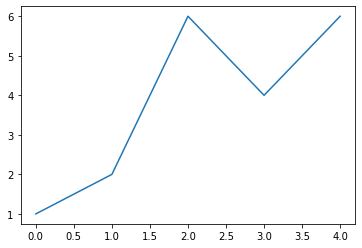

In [2]:
import matplotlib.pyplot as plt
_, axe = plt.subplots(1, 1)
line = axe.plot([1, 2, 6, 4, 6])

In [5]:
axe.lines.

In [30]:
max(line.get_ydata())

6